# TD3 

In [16]:
from datasets import load_dataset
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003",trust_remote_code=True)
# Access the training, validation, and test sets
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']
# Example: Print the first example from the training set

## Preprocessing

### Download nltk module

In [17]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')


### Fonction cleaning

In [18]:
import string
import re
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()



from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# CONVERT ALL MAJUSCULES TO MINUSCULES
def text_lowercase(text):
    return text.lower()
# CONVERT FIRST LETTER IN MINUSCULES
def format_string(text):
    return re.sub(r'^\w', lambda m: m.group(0).lower(), text)


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_whitespace(text):
    return  " ".join(text.split())

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

# stem words in the list of tokenized words
def stem_words(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

# Don't change the word with majuscule
def stem_words_conditional(sentence):
    words = sentence.split()  # Séparer en mots
    stemmed_words = [stemmer.stem(word) if not word[0].isupper() else word for word in words]
    return " ".join(stemmed_words)



In [19]:
# join words from the dataset into a single string
sentence_liste = [" ".join(sample['tokens']) for sample in train_dataset]

first_clean = []
for sentence in sentence_liste:
    sentence = text_lowercase(sentence)
    sentence = remove_punctuation(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_whitespace(sentence)
    sentence = remove_stopwords(sentence)
    
    first_clean.append(sentence)


# # delete empty sentences
# first_clean = [x for x in first_clean if x]

traited_sentences = []
second_clean = [" ".join(sample) for sample in first_clean]
for sentence in second_clean:
    sentence = stem_words(sentence)  # Appliquer le stemming conditionnel
    traited_sentences.append(sentence)

traited_sentences = [" ".join(sample) for sample in traited_sentences]
    
print(sentence_liste[30])
print(traited_sentences[30])

China on Thursday accused Taipei of spoiling the atmosphere for a resumption of talks across the Taiwan Strait with a visit to Ukraine by Taiwanese Vice President Lien Chan this week that infuriated Beijing .
china thursday accus taipei spoil atmospher resumpt talk across taiwan strait visit ukrain taiwanes vice presid lien chan week infuri beij


cleaning is useful in "classic" NLP approaches, often based on counting  
Bag of Words, TF-IDF, Clustering, Simple machine learning models SVM, NB  

So in our case, (NER) the cleaning is not necessary, moreover, it can be counterproductive.

In [ ]:
import spacy 
nlp = spacy.load("./en_ner_conll03/best_ner_model") 
text = sentence_liste[30] 
doc = nlp(text) 
entities = [(ent.text, ent.label_) for ent in doc.ents] 
print("not traited\n"+str(entities)+"\n") 

text = traited_sentences[30]
doc = nlp(text) 
entities = [(ent.text, ent.label_) for ent in doc.ents]
print("traited\n"+str(entities))

not traited
[('China', 'LOC'), ('Taipei', 'LOC'), ('Taiwan Strait', 'LOC'), ('Ukraine', 'LOC'), ('Taiwanese', 'MISC'), ('Lien Chan', 'PER'), ('Beijing', 'LOC')]

traited
[('taiwan', 'LOC')]


The cleaning will be more for the website, to remove the html tags word before and after the articles, title ...

## NER

### creating our own NER model 
using espanish corpus

In [ ]:
nltk.corpus.conll2002.fileids()
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

In [76]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

we can say that even capital letters are used to be able to recover the logic of the words so if only we put lower() it destroys information  
information is also on previous and next words, so stemmer and lemmatizer are not useful
and ponctuation is also important to keep, because it can be used to separate words and phrases.



In [70]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [72]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [ ]:
labels = list(crf.classes_)
labels.remove('O')
labels


['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

B = Beginning  
I = Inside  

LOC = location (city, country, region, etc.)  

ORG = organization (company, government, etc.)  

PER = person (proper name)  

MISC = miscellaneous entity (nationality, event, work, etc.)  

In [75]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7964686316443963

### Code to optimize the model 
using RandomizedSearchCV

In [78]:
# sorted_labels = sorted(
#     labels,
#     key=lambda name: (name[1:], name[0])
# )
# print(metrics.flat_classification_report(
#     y_test, y_pred, labels=sorted_labels, digits=3
# ))


# import scipy.stats
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import RandomizedSearchCV
# crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', labels=labels)

# # search
# rs = RandomizedSearchCV(crf, params_space,
#                         cv=3,
#                         verbose=1,
#                         n_jobs=-1,
#                         n_iter=50,
#                         scoring=f1_scorer)
# rs.fit(X_train, y_train)

# print('best params:', rs.best_params_)
# print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

### loding the NER model from td

In [31]:
import spacy 
# Load spaCy's pre-trained NER model 
nlp = spacy.load("./en_ner_conll03/best_ner_model") 

# Example text 
text = "The firm Apple was founded by Steve Jobs." 
# Process the text with spaCy 
doc = nlp(text) 
# Extract named entities 
entities = [(ent.text, ent.label_) for ent in doc.ents] 
print(entities) 

[('Apple', 'ORG'), ('Steve Jobs', 'PER')]


###  POS (Part-of-Speech)

sépare les mots en adjectif JJ , nom commun NN, verbe VB (D passé / G ing), préposition IN , etc.

In [82]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

ex = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

sent = preprocess(ex)
print(sent)

[('European', 'JJ'), ('authorities', 'NNS'), ('fined', 'VBD'), ('Google', 'NNP'), ('a', 'DT'), ('record', 'NN'), ('$', '$'), ('5.1', 'CD'), ('billion', 'CD'), ('on', 'IN'), ('Wednesday', 'NNP'), ('for', 'IN'), ('abusing', 'VBG'), ('its', 'PRP$'), ('power', 'NN'), ('in', 'IN'), ('the', 'DT'), ('mobile', 'JJ'), ('phone', 'NN'), ('market', 'NN'), ('and', 'CC'), ('ordered', 'VBD'), ('the', 'DT'), ('company', 'NN'), ('to', 'TO'), ('alter', 'VB'), ('its', 'PRP$'), ('practices', 'NNS')]


finding nominal group (NP)

In [87]:
pattern = 'NP: {<DT>?<JJ>*<NN>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
# exemple  (NP the/DT mobile/JJ phone/NN)

In [37]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)

[('European', 'JJ', 'O'),
 ('authorities', 'NNS', 'O'),
 ('fined', 'VBD', 'O'),
 ('Google', 'NNP', 'O'),
 ('a', 'DT', 'B-NP'),
 ('record', 'NN', 'I-NP'),
 ('$', '$', 'O'),
 ('5.1', 'CD', 'O'),
 ('billion', 'CD', 'O'),
 ('on', 'IN', 'O'),
 ('Wednesday', 'NNP', 'O'),
 ('for', 'IN', 'O'),
 ('abusing', 'VBG', 'O'),
 ('its', 'PRP$', 'O'),
 ('power', 'NN', 'B-NP'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'B-NP'),
 ('mobile', 'JJ', 'I-NP'),
 ('phone', 'NN', 'I-NP'),
 ('market', 'NN', 'B-NP'),
 ('and', 'CC', 'O'),
 ('ordered', 'VBD', 'O'),
 ('the', 'DT', 'B-NP'),
 ('company', 'NN', 'I-NP'),
 ('to', 'TO', 'O'),
 ('alter', 'VB', 'O'),
 ('its', 'PRP$', 'O'),
 ('practices', 'NNS', 'O')]


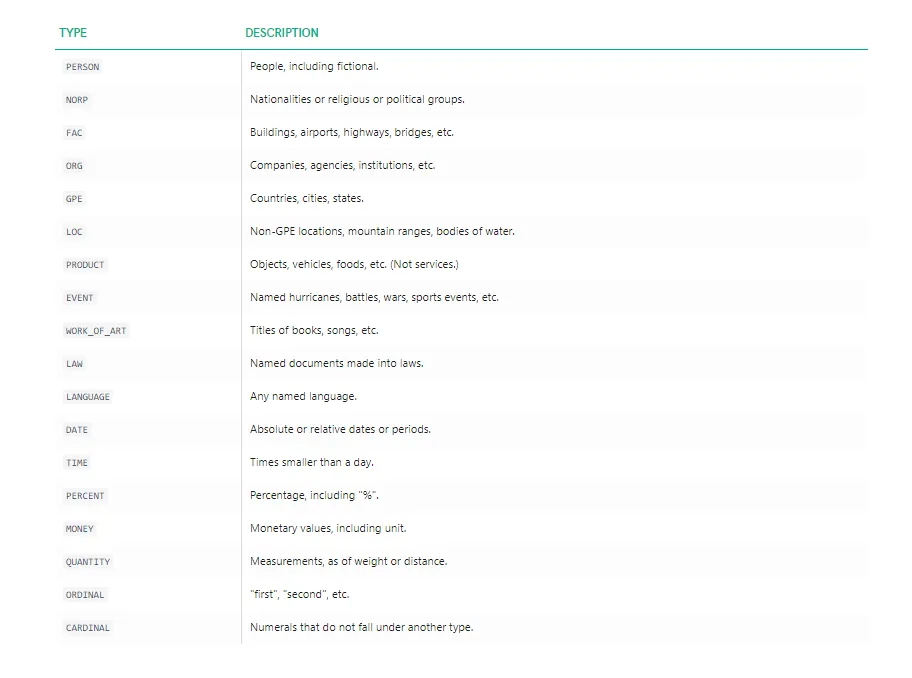

In [39]:
doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
pprint([(X.text, X.label_) for X in doc.ents])

[('European', 'MISC'), ('Google', 'PER')]


### start scrapping 

In [ ]:

from bs4 import BeautifulSoup
import requests
import re
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, "lxml")
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))
ny_bb = url_to_string('https://huggingface.co/learn/nlp-course/chapter1/1?fw=pt')
article = nlp(ny_bb)
len(article.ents)

151

In [41]:
from collections import Counter

print(article.ents)
items = [x.text for x in article.ents]
Counter(items).most_common(3)

(Sign Up, Introduction LLM Course, View, CourseML, 3D, CNZH, TW, Introduction Natural Language Processing, Large Language Models Transformers, Bias, NLP, Large Language Models, Build Reasoning Models, Events Join, Hugging Face, Spaces Faster, Switch, Sign Up, Introduction, LLMs, NLP, Hugging Face, Hugging Face Hub, NLP, LLMs While, NLP, Large Language Models, LLMs, NLP, NLP, LLMs, Large Language Models, NLP, Llama, GPT, Claude, LLMs, NLP, NLP, LLM, NLP, LLMs, Chapters, 🤗 Transformers, Transformer, Hugging Face Hub, Hub, Chapters, 🤗 Datasets, NLP, LLM, Chapter, NLP, Hub, Chapters, LLM, Requires, Python Is, Coders, AI Does, PyTorch, TensorFlow, AI, NLP, Bayes, LSTMs, Abubakar Abid, PhD, Stanford, PhD, Gradio, Python, Gradio, Hugging Face, Abubakar, Ben Burtenshaw, Machine Learning Engineer, Hugging Face, PhD, Natural Language Processing, University of Antwerp, Transformer, Matthew Carrigan, Machine Learning Engineer, Hugging Face, Dublin, Ireland, ML, Parse.ly, Trinity College Dublin, AG

[('NLP', 16), ('Hugging Face', 15), ('LLMs', 6)]

## RE

In [42]:
from spacy import displacy
displacy.render(nlp(str(traited_sentences[31])), jupyter=True, style='ent')


c:\Users\alari\miniconda3\envs\web_data\lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [43]:
import spacy 
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm") 

displacy.render(nlp(str(sentence_liste[31])), style='dep', jupyter = True, options = {'distance': 120})

In [44]:
sentence_liste[31]

'Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan , Foreign Ministry spokesman Shen Guofang told Reuters : " The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities . "'

## TRIPLES

In [45]:
# Load spaCy's pre-trained model 
nlp = spacy.load("en_core_web_sm") 
# Example text 
text = "Apple was founded by Steve Jobs." 
# Process the text with spaCy 
doc = nlp(text) 
# Extract relations 
relations = [] 
for token in doc: 
    print(token.text, token.dep_, token.head.text)
    if (token.dep_ == "nsubj" or token.dep_ == "nsubjpass") and  token.head.dep_ == "ROOT": 
        subject = token.text 
        predicate = token.head.text 
        for child in token.head.children: 
            if child.dep_ == "prep" or child.dep_ == "agent": 
                for obj in child.children: 
                    if obj.dep_ == "pobj": 
                                            relations.append((subject, predicate, obj.text)) 
print(relations) 

Apple nsubjpass founded
was auxpass founded
founded ROOT founded
by agent founded
Steve compound Jobs
Jobs pobj by
. punct founded
[('Apple', 'founded', 'Jobs')]


## SPARQL

In [46]:
from rdflib import Graph, URIRef, Literal, Namespace 
from rdflib.namespace import RDF, RDFS
g = Graph() 
EX = Namespace("http://example.org/") 

g.add((URIRef(EX.Apple), RDF.type, URIRef(EX.Company))) 
g.add((URIRef(EX.SteveJobs), RDF.type, URIRef(EX.Person))) 
g.add((URIRef(EX.Apple), URIRef(EX.founded_by), URIRef(EX.SteveJobs))) 
# Serialize the graph in RDF/XML format 
print(g.serialize(format="xml"))


<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:ns1="http://example.org/"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
>
  <rdf:Description rdf:about="http://example.org/Apple">
    <rdf:type rdf:resource="http://example.org/Company"/>
    <ns1:founded_by rdf:resource="http://example.org/SteveJobs"/>
  </rdf:Description>
  <rdf:Description rdf:about="http://example.org/SteveJobs">
    <rdf:type rdf:resource="http://example.org/Person"/>
  </rdf:Description>
</rdf:RDF>



In [47]:
query = """ 
SELECT ?subject ?predicate 
WHERE { 
  ?subject ?predicate <http://example.org/SteveJobs> 
} 
"""
for row in g.query(query): 
    print(f"{row.subject} {row.predicate}  ")

http://example.org/Apple http://example.org/founded_by  


## Scrapping

In [48]:
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options 
from bs4 import BeautifulSoup 
def fetch_reuters_articles(): 
    # Configure Chrome options for headless browsing (optional) 
    chrome_options = Options() 
    #chrome_options.add_argument("--headless")  # Run Chrome in headless 
    chrome_options.add_argument("--no-sandbox")  # Bypass OS security 
    chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome 
    # Initialize the Chrome webdriver 
    driver = webdriver.Chrome(options=chrome_options) 
    # URL of Reuters World section 
    url = "https://www.reuters.com/world/" 
    # Load the page using Selenium 
    driver.get(url) 
    # Get the page source after JavaScript execution 
    page_source = driver.page_source 
    # Close the browser 
    driver.quit() 
    # Parse the HTML content with BeautifulSoup 
    articles = []
    soup = BeautifulSoup(page_source, "html.parser") 
    for article in soup.find_all('article', limit=10): 
        title = article.find('h3').get_text() 
        link = article.find('a')['href'] 
        article_url = f"https://www.reuters.com{link}" 
        article_response = requests.get(article_url) 
        article_soup = BeautifulSoup(article_response.content, 'html.parser') 
        content = article_soup.find('div', class_='StandardArticleBody_body').get_text() 
        publication_date = article_soup.find('meta', {'name': 'article:published_time'})['content'] 
        articles.append({ 
        'title': title, 
        'url': article_url, 
        'content': content, 
        'publication_date': publication_date 
                }) 
    return articles 
articles = fetch_reuters_articles() 
for article in articles: 
    print(article['title'], article['publication_date']) 
    print(article['content'][:200])  # Print the first 200 characters of 
    # content
    print()

In [88]:
from selenium.webdriver.common.by import By
import time
# Configure Chrome options for headless browsing (optional) 
chrome_options = Options() 
#chrome_options.add_argument("--headless")  # Run Chrome in headless 
chrome_options.add_argument("--no-sandbox")  # Bypass OS security 
chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome 
# Initialize the Chrome webdriver 
driver = webdriver.Chrome(options=chrome_options) 
# URL of Reuters World section 
url = "https://www.reuters.com/world/" 
# Load the page using Selenium 
driver.get(url) 
time.sleep(0.5)  # Wait for the page to load
driver.find_element(By.CSS_SELECTOR,"#onetrust-reject-all-handler").click()
driver.quit()  # Close the browser

The web site detect a robot, so it isn't possible to scrape the data with selenium.


# TD4

## Scraping Wikipedia :

### Found articles

In [138]:
import requests

def rechercher_articles_wikipedia(mot_cle, nombre_resultats=10):
    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "list": "search",
        "srsearch": mot_cle,
        "format": "json",
        "srlimit": nombre_resultats,
    }

    response = requests.get(url, params=params)
    data = response.json()

    articles = []
    for result in data["query"]["search"]:
        titre = result["title"]
        lien = f"https://en.wikipedia.org/wiki/{titre.replace(' ', '_')}"
        articles.append((titre, lien))

    return articles

# Exemple d'utilisation
mot_cle = "Seconde Guerre mondiale"
articles = rechercher_articles_wikipedia(mot_cle)

# adding better results
articles= articles[:-1]
articles.append(("Seconde Guerre mondiale", "https://en.wikipedia.org/wiki/World_War_II"))

### Extracting the text form articles

In [139]:
from bs4 import BeautifulSoup
import requests
import re
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, "lxml")
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))

wiki_articles=[]
for titre, lien in articles:
    print(titre)
    print(lien)
    wiki_articles.append(url_to_string(lien))

# TEST
#ny_bb = url_to_string('https://en.wikipedia.org/wiki/Belgium_in_World_War_II')



List of last surviving World War II veterans
https://en.wikipedia.org/wiki/List_of_last_surviving_World_War_II_veterans
German occupation of Belgium during World War II
https://en.wikipedia.org/wiki/German_occupation_of_Belgium_during_World_War_II
French West Africa in World War II
https://en.wikipedia.org/wiki/French_West_Africa_in_World_War_II
Bombing of Rome in World War II
https://en.wikipedia.org/wiki/Bombing_of_Rome_in_World_War_II
Filthy Thirteen
https://en.wikipedia.org/wiki/Filthy_Thirteen
Art and World War II
https://en.wikipedia.org/wiki/Art_and_World_War_II
Japanese occupation of Cambodia
https://en.wikipedia.org/wiki/Japanese_occupation_of_Cambodia
Belgium in World War II
https://en.wikipedia.org/wiki/Belgium_in_World_War_II
Apostolic Nunciature to the Philippines
https://en.wikipedia.org/wiki/Apostolic_Nunciature_to_the_Philippines
Seconde Guerre mondiale
https://en.wikipedia.org/wiki/World_War_II


## Preprocessing the text

### Removing part that we don't need 

In [140]:
def remove_after_notes(text):
    # removing everything after "Notes", "References", or "See also" sections
    pattern = r"(notes\s*\[edit\]|references\s*\[edit\]|see also\s*\[edit\])"
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return text[:match.start()].strip()
    return text

def remove_before(text):
    pattern = r"from wikipedia, the free encyclopedia"
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return text[match.end():].strip()
    return text

### Delete reference numbers and edits 

In [141]:
def remove_wiki_number(text):
    sentence_wiki=text.split('.')
    traite_wiki_sen=[]
    final=[]
    regex = re.compile(r'\[(\d+)\]')
    for i in range(len(sentence_wiki)):
        traite_wiki_sen.append(regex.sub('', sentence_wiki[i]))

    return '. '.join(traite_wiki_sen)


# suprime moi tout les mot qui ont [a-x]+[edit] dedans
def remove_edit(text):
    pattern = r'\b\w+\[edit\]'
    return re.sub(pattern, "", text)


In [142]:
news=[]
for ny_bb in wiki_articles:
    print(len(ny_bb))
    new=remove_after_notes(ny_bb)
    print(len(new))
    new=remove_before(new)
    print(len(new))
    new=remove_wiki_number(new)
    print(len(new))
    new=remove_edit(new)
    print(len(new))
    news.append(new)


69937
29586
28590
27766
27751
72229
41212
39446
38931
38676
19501
5652
4524
4544
4511
29585
19180
17837
17721
17607
15288
10302
9307
9313
9272
36615
24509
23263
23385
23268
15785
8555
7320
7303
7256
64620
32860
31316
30919
30713
13402
8284
6885
6927
6845
192526
192526
188384
189479
189479


In [143]:
wwentities=[]
for i in range(len(news)):
    article = nlp(news[i])
    print(len(article.ents))
    print(article.ents)
    wwentities.append(article.ents)


1261
(World War II, About 70 million, World War II, between 1939 and 1945, Background, 1917 or, December 2020, 102, the Battle of the Lys, Belgian Armed Forces, Antonio Amoretti, 1927-09-11)11, September 1927, December 2022(2022-12-23, 95, Italian, Four Days, Naples, Italian, Italy, Egon Andersen, 1920-04-14)14, April 1920 August 2017, 97, the Hvidsten Group, Danish, Denmark Bud Anderson, 1922-01-13)13, January 1922, May 2024, 102, American, US Army Air Forces, Viljo Aronniemi, 1925 or, 1926 31 January 2025, 99, Finnish, the Battle of Teikari, Finnish Army, 1918, 1919, August 2021, 102, Georgian, Texel, Georgian Legion, Germany, Jale Bainisika, 1914 or, February 2020, 105, Fiji, Fiji Infantry Regiment, Richard M.  Barancik, 1924-10-19)19, October 1924, July 2023(2023-07-14, 98, Monuments Man, 1, 1920-07-08)8, July 1920 28, 104, Polish, the Battle of Pszczyna, Polish, Land Forces  Poland Clarence Beavers, 1921-06-12)12 June 1921, December 2017(2017-12-04, 96, the 555th Parachute Infantr

### Find entities in each articles

In [144]:
# Append the entities of each articles
wwentities2 = [item for sublist in wwentities for item in sublist]
wwentities2=[x.text for x in wwentities2]
print(len(wwentities2))
wwentities2 = [x.lower() for x in wwentities2]
wwentities2 = list(set(wwentities2))
print(len(wwentities2))

def stem_words(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

wwentities2 = [ remove_numbers(x) for x in wwentities2]
wwentities2 = [stem_words(x) for x in wwentities2]
wwentities2 = [" ".join(x) for x in wwentities2]
wwentities2 = [ remove_punctuation(x) for x in wwentities2]
wwentities2 = [ remove_whitespace(x) for x in wwentities2]

wwentities2= list(set(wwentities2))
print(len(wwentities2))

12282
5400
3650


In [145]:
wwentities2

['',
 'jeffrey',
 'the uk postwar welfar state',
 'john agnew',
 'gessler',
 'oper overlord and',
 'pacif theatr middl eastern theatr interwar',
 'thoma',
 'r a',
 'maastricht',
 'dower',
 'fine art',
 'an estim',
 'a concis histori',
 'bibliographi categori vtehistori of',
 'nj',
 'serb',
 'eichengreen',
 'the showdown with japan aug',
 'rd battalion',
 'itali michael',
 'patriot war',
 'copi',
 'loui g',
 'corpo volontari',
 'michel thoma',
 'the lower dnieper offens',
 'levin',
 'group g',
 'the few',
 'flemish nation union verdinaso',
 'dc',
 'anzio',
 'edward seybolt',
 'the seminol counti news',
 'us govern print offic',
 'ss',
 'arbeiterillustriertezeitung',
 'einsatzgrupp c schutzstaffel',
 'algier',
 'montefranco',
 'afrika korp',
 'korean',
 'san jose',
 'brunei',
 'the begin of',
 'radio belgiqu',
 'versail',
 'a few month',
 'jackson',
 'manduria',
 'edmond schmickrath',
 'ranger',
 'britannica',
 'buddhist',
 'de facto embargo',
 'paul von hindenburg',
 'piccadilli willi g

In [146]:
def extract_relations(doc):
    relations = [] 
    RELEVANT_PREPOSITIONS = {"to", "by", "with", "for", "in", "on"}

    for token in doc: 

        if (token.dep_ == "nsubj" or token.dep_ == "nsubjpass") and  token.head.dep_ == "ROOT": 
            #print(token.text, token.dep_, token.head.text)
            subject = token.text 
            predicate = token.head.text 
            for child in token.head.children: 
                if (child.dep_ == "prep" or child.dep_ == "agent") and child.text.lower() in RELEVANT_PREPOSITIONS: 
                    for obj in child.children: 
                        if obj.dep_ == "pobj": 
                                                relations.append((subject, predicate, obj.text)) 
    return relations

### Get the sentences of the wikipedia articles

In [147]:
wiki_sentencess = []
for new in news:
    wiki_sentences = new.split('.')
    print(wiki_sentences[1])
    wiki_sentencess.append(wiki_sentences)

  About 70 million people fought in World War II between 1939 and 1945
  For a general history of Belgium in the conflict, see Belgium in World War II
  Please help to improve this article by introducing more precise citations
  Arnold  Renato Sandalli   Albert Kesselring Casualties and losses 600 aircraft shot down  3,600 air crew 719 casualties1,659 injured Rome, along with Vatican City, was bombed several times during 1943 and 1944, primarily by Allied and to a smaller degree by Axis aircraft, before the city was liberated by the Allies on June 4, 1944
  The idea was McNiece's, to honor his Native American heritage and to energize the men for the danger ahead
  Please help improve it or discuss these issues on the talk page
  Vichy France, which was a client state of Germany, nominally maintained the French protectorate over Cambodia and other parts of Indochina during most of the Japanese occupation
  After 18 days of fighting, in which Belgian forces were pushed back into a small 

### Creation of relations

In [148]:
article_relations = []
article_relationss = []
for wiki_sentences in wiki_sentencess:
    for i in range(len(wiki_sentences)):
        doc = nlp(wiki_sentences[i])
        relations = extract_relations(doc)
        print(f"Relations in sentence {i}:")
        for relation in relations:
            print(relation)
            article_relations.append(relation)
    article_relationss.append(article_relations)

Relations in sentence 0:
Relations in sentence 1:
('people', 'fought', 'II')
Relations in sentence 2:
Relations in sentence 3:
Relations in sentence 4:
Relations in sentence 5:
Relations in sentence 6:
Relations in sentence 7:
Relations in sentence 8:
Relations in sentence 9:
Relations in sentence 10:
Relations in sentence 11:
Relations in sentence 12:
Relations in sentence 13:
Relations in sentence 14:
Relations in sentence 15:
Relations in sentence 16:
Relations in sentence 17:
Relations in sentence 18:
Relations in sentence 19:
Relations in sentence 20:
Relations in sentence 21:
Relations in sentence 22:
Relations in sentence 23:
Relations in sentence 24:
Relations in sentence 25:
Relations in sentence 26:
Relations in sentence 27:
Relations in sentence 28:
Relations in sentence 29:
Relations in sentence 30:
Relations in sentence 31:
Relations in sentence 32:
Relations in sentence 33:
Relations in sentence 34:
Relations in sentence 35:
Relations in sentence 36:
Relations in sentence

In [149]:
article_relationss

[[('people', 'fought', 'II'),
  ('parade', 'began', 'May'),
  ('administration', 'established', 'Belgium'),
  ('They', 'assisted', 'service'),
  ('civilians', 'were', 'danger'),
  ('Jews', 'suffered', 'camps'),
  ('SS', 'gained', 'Belgium'),
  ('forces', 'arrived', 'September'),
  ('forces', 'arrived', 'Belgium'),
  ('Belgians', 'killed', 'total'),
  ('Empire', 'invaded', 'War'),
  ('Empire', 'invaded', 'I'),
  ('Germans', 'invaded', 'May'),
  ('government', 'fled', 'France'),
  ('Administration', 'established', '1940'),
  ('Militärverwaltung', 'created', 'Germans'),
  ('Administration', 'created', 'Germans'),
  ('Committee', 'enabled', 'practice'),
  ('administration', 'replaced', 'July'),
  ('administration', 'replaced', 'government'),
  ('Germans', 'forced', '1944'),
  ('article', 'became', '1934'),
  ('King', 'surrendered', 'May'),
  ('King', 'surrendered', 'Germans'),
  ('He', 'denounced', 'Minister'),
  ('Leopold', 'visited', 'November'),
  ('Leopold', 'visited', 'Berchtesgaden')

In [150]:
# Load spaCy's pre-trained model 
nlp = spacy.load("en_core_web_sm") 
# Example text 
text = "Apple was founded by Steve Jobs." 
text=wiki_sentences[5]
# Process the text with spaCy 
doc = nlp(text) 
# Extract relations  
extract_relations(doc)

[]

In [151]:
from rdflib import Graph, URIRef, Namespace 
from rdflib.namespace import RDF 
# Create a new RDF graph 
g = Graph() 
# Define namespaces 
EX = Namespace("http://example.org/") 
# Add triples to the graph 
g.add((URIRef(EX.Apple), RDF.type, URIRef(EX.Company))) 
g.add((URIRef(EX.SteveJobs), RDF.type, URIRef(EX.Person))) 
g.add((URIRef(EX.Apple), URIRef(EX.founded_by), URIRef(EX.SteveJobs))) 
# Serialize the graph in RDF/XML format 
print(g.serialize(format="xml")) 
# Perform a SPARQL query 
query = """ 
SELECT ?subject ?predicate 
WHERE { 
  ?subject ?predicate <http://example.org/SteveJobs> 
} 
"""
for row in g.query(query): 
    print(f"{row.subject} {row.predicate} ")

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:ns1="http://example.org/"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
>
  <rdf:Description rdf:about="http://example.org/Apple">
    <rdf:type rdf:resource="http://example.org/Company"/>
    <ns1:founded_by rdf:resource="http://example.org/SteveJobs"/>
  </rdf:Description>
  <rdf:Description rdf:about="http://example.org/SteveJobs">
    <rdf:type rdf:resource="http://example.org/Person"/>
  </rdf:Description>
</rdf:RDF>

http://example.org/Apple http://example.org/founded_by 


In [152]:
import numpy as np
from pykeen.triples import TriplesFactory

# Ensure article_relations contains only valid triples
valid_triples = [relation for relation in article_relations if len(relation) == 3]

# Convert to a NumPy array
triples_array = np.array(valid_triples, dtype=str)

# Create a TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)


In [153]:
triples

[('parade', 'began', 'May'),
 ('administration', 'established', 'Belgium'),
 ('They', 'assisted', 'service'),
 ('civilians', 'were', 'danger'),
 ('Jews', 'suffered', 'camps'),
 ('SS', 'gained', 'Belgium'),
 ('forces', 'arrived', 'September'),
 ('forces', 'arrived', 'Belgium'),
 ('Belgians', 'killed', 'total'),
 ('Empire', 'invaded', 'War'),
 ('Empire', 'invaded', 'I'),
 ('Germans', 'invaded', 'May'),
 ('government', 'fled', 'France'),
 ('Administration', 'established', '1940'),
 ('Militärverwaltung', 'created', 'Germans'),
 ('Administration', 'created', 'Germans'),
 ('Committee', 'enabled', 'practice'),
 ('administration', 'replaced', 'July'),
 ('administration', 'replaced', 'government'),
 ('Germans', 'forced', '1944'),
 ('article', 'became', '1934'),
 ('King', 'surrendered', 'May'),
 ('King', 'surrendered', 'Germans'),
 ('He', 'denounced', 'Minister'),
 ('Leopold', 'visited', 'November'),
 ('Leopold', 'visited', 'Berchtesgaden'),
 ('Leopold', 'held', 'rest'),
 ('he', 'married', '1941

In [154]:
print(all(isinstance(x, str) for triple in triples for x in triple)) #verifiy we have 3 strings per triple

True


# KG Embedding training pipeline

In [155]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

triples_array = np.array(triples, dtype=str)
tf = TriplesFactory.from_labeled_triples(triples_array)

training, validation, testing = tf.split([0.8, 0.1, 0.1], method='coverage')

model_results = {}
models = ['TransE', 'DistMult', 'ComplEx']

for model_name in models:
    print(f"Training {model_name}...")
    results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model=model_name,
    model_kwargs=dict(embedding_dim=50),
    epochs=100,
    training_kwargs=dict(batch_size=32),
    random_seed=42,
)
    model_results[model_name] = results


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [73, 71, 71]
INFO:pykeen.pipeline.api:Using device: None


Training TransE...


Training epochs on cpu: 100%|██████████| 100/100 [00:46<00:00,  2.16epoch/s, loss=0.00846, prev_loss=0.0112]
Evaluating on cpu:   0%|          | 0.00/71.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 71.0/71.0 [00:00<00:00, 310triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.25s seconds
INFO:pykeen.pipeline.api:Using device: None


Training DistMult...


Training epochs on cpu: 100%|██████████| 100/100 [00:46<00:00,  2.15epoch/s, loss=0.659, prev_loss=0.666]
Evaluating on cpu:   0%|          | 0.00/71.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 71.0/71.0 [00:00<00:00, 642triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: None


Training ComplEx...


Training epochs on cpu: 100%|██████████| 100/100 [00:34<00:00,  2.94epoch/s, loss=0.591, prev_loss=0.598]
Evaluating on cpu:   0%|          | 0.00/71.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 71.0/71.0 [00:00<00:00, 706triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds


### Evaluation metrics

In [156]:
# Evaluation metrics
def evaluate_model(results, model_name):
    metrics = results.metric_results.to_dict()
    real = metrics.get('realistic', {})
    
    print(f"\nResults for {model_name} (realistic ranking):")
    for k in ['mean_rank', 'mean_reciprocal_rank', 'hits_at_1', 'hits_at_3', 'hits_at_10']:
        if k in real:
            print(f"{k}: {real[k]:.4f}")



# Display all models' metrics
for name, result in model_results.items():
    evaluate_model(result, name)

# Comparison table
def create_comparison_table(model_results):
    metrics_to_extract = ['mean_rank', 'mean_reciprocal_rank', 'hits_at_10']
    comparison = {}

    for name, result in model_results.items():
        real = result.metric_results.to_dict().get('realistic', {})
        comparison[name] = {
            metric: round(real.get(metric, -1), 4) for metric in metrics_to_extract
        }

    return pd.DataFrame(comparison).T


create_comparison_table(model_results)



Results for TransE (realistic ranking):

Results for DistMult (realistic ranking):

Results for ComplEx (realistic ranking):


,mean_rank,mean_reciprocal_rank,hits_at_10
TransE,-1,-1,-1
DistMult,-1,-1,-1
ComplEx,-1,-1,-1


We shouldn't get -1s, we should get evaluation metrics

In [157]:
print("Training:", training.num_triples)
print("Validation:", validation.num_triples)
print("Testing:", testing.num_triples)


Training: 566
Validation: 71
Testing: 71


In [158]:
results.metric_results.to_dict()


{'head': {'optimistic': {'adjusted_inverse_harmonic_mean_rank': 0.010822920200432806,
   'median_rank': 310.0,
   'inverse_harmonic_mean_rank': 0.021824461892351533,
   'inverse_arithmetic_mean_rank': 0.003427798966832424,
   'adjusted_geometric_mean_rank_index': 0.1421166422172473,
   'median_absolute_deviation': 237.21635496089633,
   'inverse_median_rank': 0.0032258064516129032,
   'z_arithmetic_mean_rank': 1.1390998320091565,
   'adjusted_arithmetic_mean_rank_index': 0.07817349559004128,
   'geometric_mean_rank': 202.18822804769476,
   'z_inverse_harmonic_mean_rank': 1.8118068465379265,
   'arithmetic_mean_rank': 291.7323943661972,
   'harmonic_mean_rank': 45.820144612612594,
   'adjusted_arithmetic_mean_rank': 0.9220735860395755,
   'count': 71.0,
   'z_geometric_mean_rank': 1.2292797498217034,
   'standard_deviation': 179.84500038052946,
   'variance': 32344.22416187264,
   'inverse_geometric_mean_rank': 0.0049458863636912985,
   'hits_at_1': 0.014084507042253521,
   'hits_at_3':

In [159]:
import pprint
pprint.pprint(results.metric_results.to_dict())


{'both': {'optimistic': {'adjusted_arithmetic_mean_rank': 0.9235189309576837,
                         'adjusted_arithmetic_mean_rank_index': 0.07672371419634472,
                         'adjusted_geometric_mean_rank_index': 0.12867539074702983,
                         'adjusted_hits_at_k': -0.001781715355267284,
                         'adjusted_inverse_harmonic_mean_rank': 0.007251381531736019,
                         'arithmetic_mean_rank': 292.01408450704224,
                         'count': 142.0,
                         'geometric_mean_rank': 204.53512012966684,
                         'harmonic_mean_rank': 54.649684202345455,
                         'hits_at_1': 0.007042253521126761,
                         'hits_at_10': 0.014084507042253521,
                         'hits_at_3': 0.014084507042253521,
                         'hits_at_5': 0.014084507042253521,
                         'inverse_arithmetic_mean_rank': 0.0034244923551825595,
                         'inver

In [160]:
# Check what entities and relations are available
factory = model_results['TransE'].training
print("Example entities:", list(factory.entity_labeling.label_to_id.keys())[:5])
print("Example relations:", list(factory.relation_labeling.label_to_id.keys())[:5])

Example entities: ['-', '1,000', '1610', '1900', '1920']
Example relations: ['Transferred', 'Turns', 'Was', '^', 'abandoned']


### Entity similarity

In [161]:
def analyze_entity_neighborhood(result_obj, entity_name, k=5):
    # Get the actual model from the pipeline result
    model = result_obj.model
    factory = result_obj.training  # TriplesFactory
    
    labels = factory.entity_labeling.label_to_id
    if entity_name not in labels:
        print(f"Entity '{entity_name}' not found in training set.")
        return
    
    entity_id = labels[entity_name]
    
    # Access entity representations differently - we need to go through model's entity_representations
    entity_representations = model.entity_representations[0]._embeddings.weight.detach().numpy()
    
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np
    
    similarities = cosine_similarity([entity_representations[entity_id]], entity_representations)[0]
    most_similar = np.argsort(similarities)[-k-1:-1][::-1]
    reverse_labels = {v: k for k, v in labels.items()}
    
    print(f"\nMost similar entities to '{entity_name}':")
    for idx in most_similar:
        print(f"{reverse_labels[idx]}: {similarities[idx]:.4f}")

In [162]:
analyze_entity_neighborhood(model_results['TransE'], 'surrender', k=5)


Most similar entities to 'surrender':
government: 0.4464
Chongqing: 0.3647
Austria: 0.3378
total: 0.3327
occupation: 0.3324


### Link prediction

In [163]:
import torch

def predict_tail_entities(result_obj, head_name, relation_name, k=5):
    """Predict the most likely tail entities for a given head and relation."""
    model = result_obj.model
    factory = result_obj.training
    
    # Get label mappings
    entity_labels = factory.entity_labeling.label_to_id
    relation_labels = factory.relation_labeling.label_to_id
    
    # Create reverse mapping right away
    reverse_entity_labels = {v: k for k, v in entity_labels.items()}
    
    try:
        head_id = entity_labels[head_name]
        rel_id = relation_labels[relation_name]
    except KeyError as e:
        print(f"Not found: {e}")
        return []
    
    # Get embeddings
    head_embedding = model.entity_representations[0]._embeddings.weight[head_id]
    relation_embedding = model.relation_representations[0]._embeddings.weight[rel_id]
    
    # For TransE: target = head + relation
    target = head_embedding + relation_embedding
    
    # All entity embeddings
    all_entity_embeddings = model.entity_representations[0]._embeddings.weight
    
    # Calculate distances (negative scores for TransE)
    distances = torch.norm(all_entity_embeddings - target.unsqueeze(0), dim=1)
    scores = -distances  # Higher score = better prediction
    
    # Get top k indices (exclude the head entity itself)
    # Create a mask to exclude the head entity
    mask = torch.ones_like(scores, dtype=torch.bool)
    mask[head_id] = False
    masked_scores = scores.clone()
    masked_scores[~mask] = float('-inf')  # Set head entity score to -infinity
    
    # Get top k
    top_k_values, top_k_indices = torch.topk(masked_scores, k=min(k, len(masked_scores)-1))
    
    # Create results with proper entity names
    results = []
    for idx, score in zip(top_k_indices, top_k_values):
        idx_item = idx.item()
        if idx_item in reverse_entity_labels:
            entity_name = reverse_entity_labels[idx_item]
        else:
            entity_name = f"Unknown-{idx_item}"
        results.append((entity_name, score.item()))
    
    return results

In [164]:
results = predict_tail_entities(model_results['TransE'], 'Belgium', 'surrendered', k=10)
print("\nPredicted tail entities:")
for entity, score in results:
    print(f"{entity}: {score:.4f}")


Predicted tail entities:
aftermath: -1.4476
trouble: -1.4604
RAF: -1.4824
defeats: -1.4829
capacity: -1.4840
treaty: -1.4936
organisations: -1.4993
Conference: -1.5027
rejection: -1.5127
month: -1.5169


### t-SNE Visualization

In [165]:
def visualize_entity_clusters(result_obj, focus_entities=None, n_neighbors=15):
    """
    Visualize entity embeddings with a focus on specific entities and their neighbors.
    
    Args:
        result_obj: PyKeen model result object
        focus_entities: List of entity names to focus on
        n_neighbors: Number of nearest neighbors to highlight for each focus entity
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    from matplotlib.colors import ListedColormap
    
    model = result_obj.model
    factory = result_obj.training
    
    # Get entity labels
    entity_labels = factory.entity_labeling.label_to_id
    reverse_entity_labels = {v: k for k, v in entity_labels.items()}
    
    # Get entity embeddings
    embeddings = model.entity_representations[0]._embeddings.weight.detach().numpy()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
    reduced = tsne.fit_transform(embeddings)
    
    # Create a figure
    plt.figure(figsize=(15, 12))
    
    # Plot all points with low alpha
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.2, color='gray', s=30)
    
    # Colors for different focus entities
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    
    # If focus entities are provided, highlight them and their neighbors
    if focus_entities:
        for i, entity_name in enumerate(focus_entities):
            if entity_name in entity_labels:
                entity_id = entity_labels[entity_name]
                entity_emb = embeddings[entity_id]
                
                # Calculate distances to all other entities
                distances = np.linalg.norm(embeddings - entity_emb, axis=1)
                
                # Get nearest neighbors
                nearest_indices = np.argsort(distances)[:n_neighbors+1]  # +1 to include the entity itself
                
                # Highlight these points with a distinct color
                color = colors[i % len(colors)]
                plt.scatter(reduced[nearest_indices, 0], reduced[nearest_indices, 1], 
                            alpha=0.9, color=color, s=80, label=f"Cluster around '{entity_name}'")
                
                # Add labels for these points
                for idx in nearest_indices:
                    plt.annotate(reverse_entity_labels[idx], 
                                 (reduced[idx, 0], reduced[idx, 1]),
                                 fontsize=10, alpha=0.8)
    
    plt.title("t-SNE Visualization of Entity Embeddings")
    plt.legend()
    plt.tight_layout()
    plt.show()

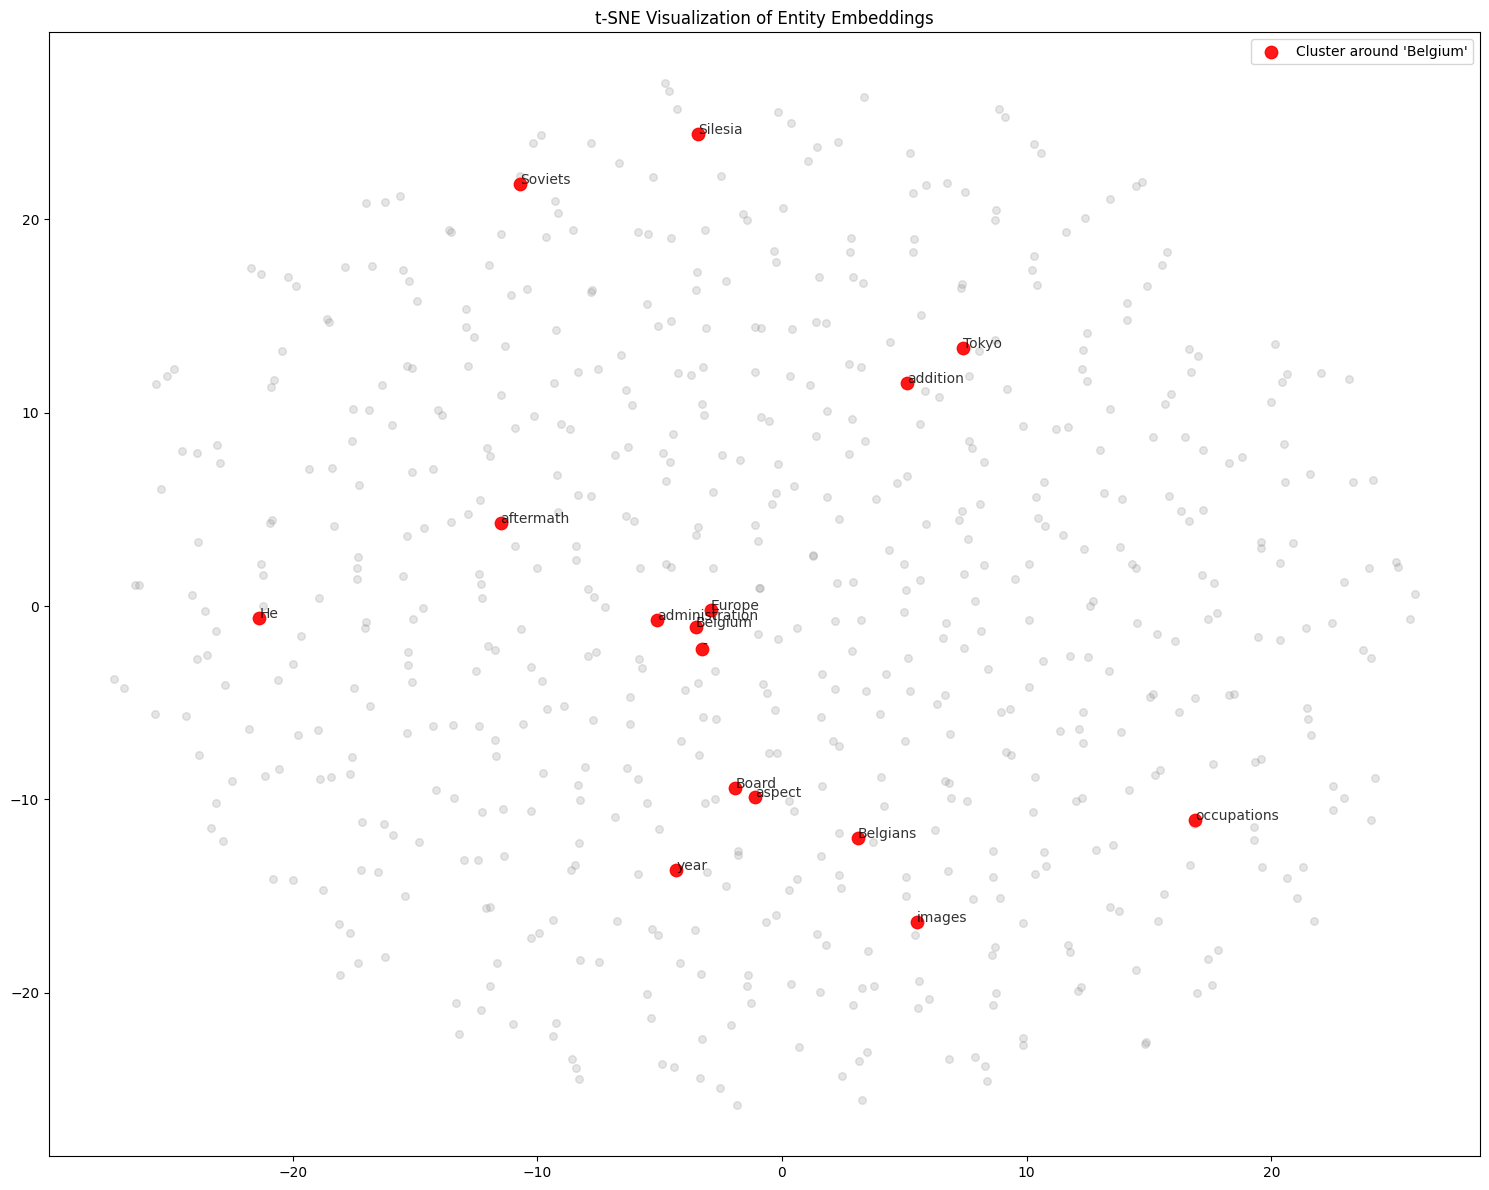

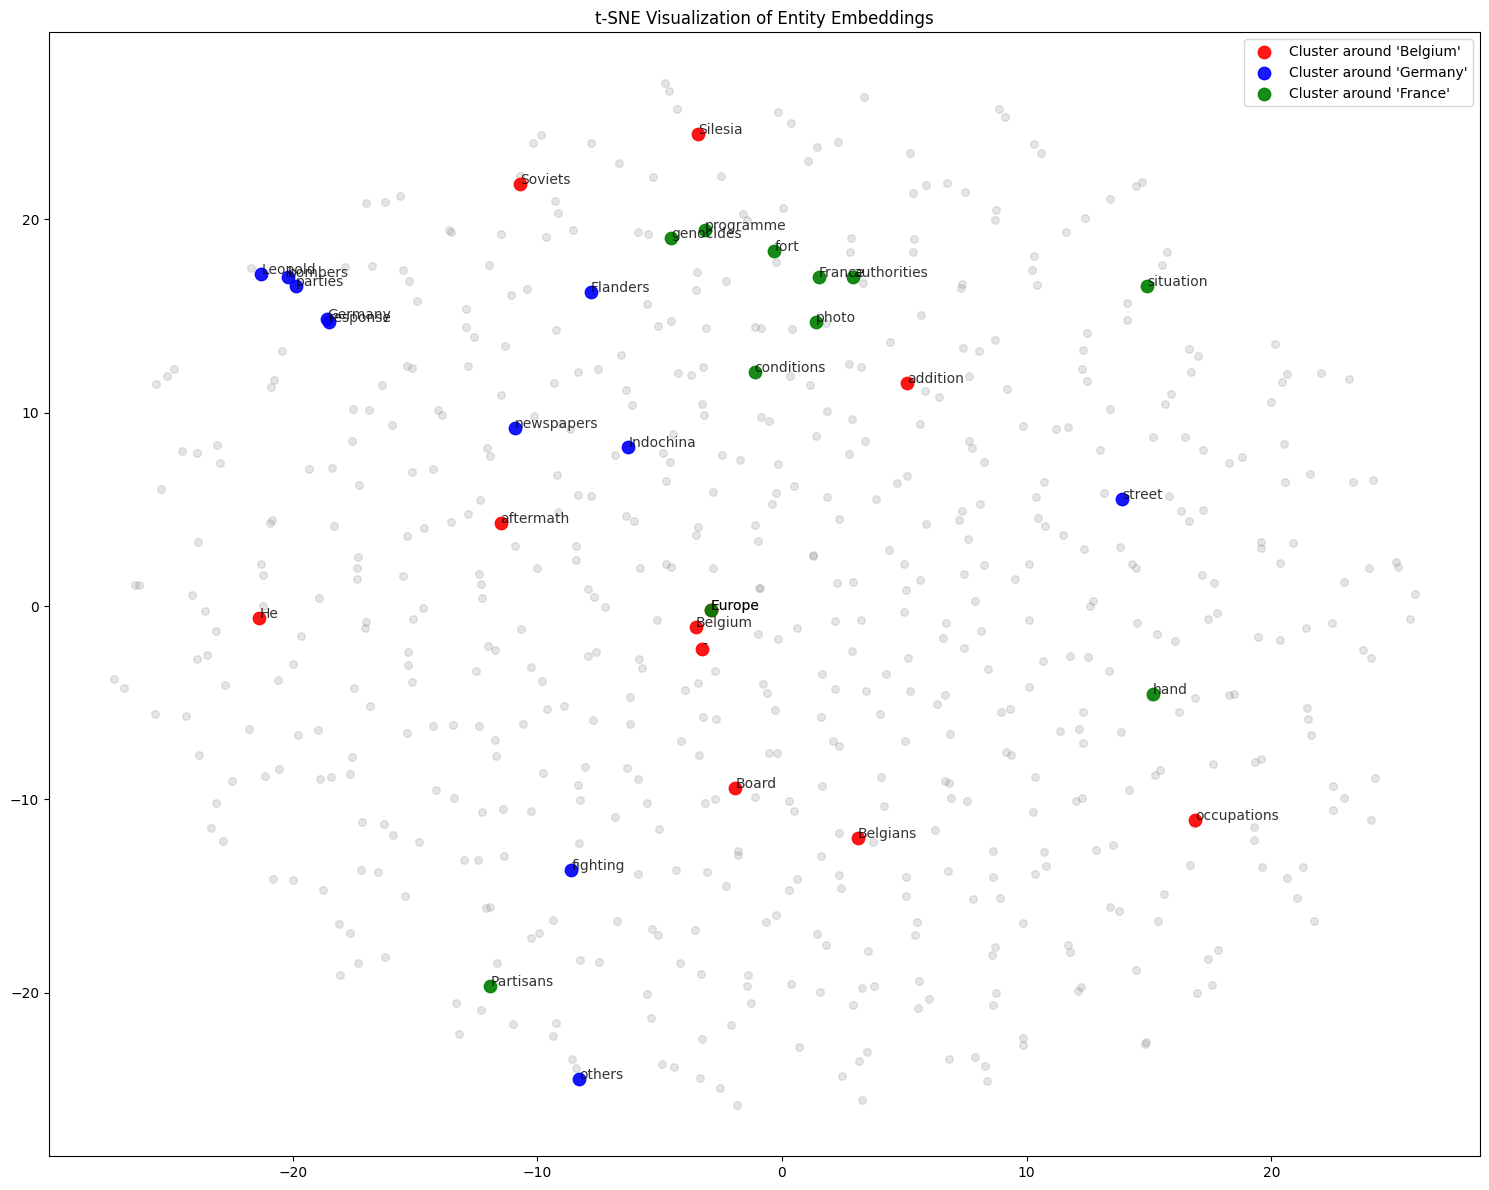

In [166]:
# Focus on 'Belgium' and find its nearest neighbors in the embedding space
visualize_entity_clusters(model_results['TransE'], focus_entities=['Belgium'])

# Compare multiple entities of interest
visualize_entity_clusters(model_results['TransE'], 
                         focus_entities=['Belgium', 'Germany', 'France'], 
                         n_neighbors=10)

### DBpedia Enrichment

In [167]:
from SPARQLWrapper import SPARQLWrapper, JSON

def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label .
        FILTER(LANG(?label) = 'en')
    }} LIMIT 10
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    triples = []
    for result in results["results"]["bindings"]:
        related = result["related"]["value"]
        relation = result["relation"]["value"]
        triples.append((entity_name, relation, related))
    return triples


In [168]:
extra_triples = enrich_with_dbpedia("Belgium")


In [169]:
extra_triples

[('Belgium',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
  'http://dbpedia.org/ontology/Place'),
 ('Belgium',
  'http://dbpedia.org/ontology/wikiPageWikiLink',
  'http://dbpedia.org/resource/Carolingian_Dynasty'),
 ('Belgium',
  'http://dbpedia.org/ontology/wikiPageWikiLink',
  'http://dbpedia.org/resource/Cartography'),
 ('Belgium',
  'http://dbpedia.org/ontology/wikiPageWikiLink',
  'http://dbpedia.org/resource/Beer'),
 ('Belgium',
  'http://www.w3.org/2004/02/skos/core#broader',
  'http://dbpedia.org/resource/Category:Benelux'),
 ('Belgium',
  'http://purl.org/dc/terms/subject',
  'http://dbpedia.org/resource/Category:Benelux'),
 ('Belgium',
  'http://dbpedia.org/ontology/wikiPageWikiLink',
  'http://dbpedia.org/resource/Category:Benelux'),
 ('Belgium',
  'http://purl.org/dc/terms/subject',
  'http://dbpedia.org/resource/Category:Countries_of_Europe_with_multiple_official_languages'),
 ('Belgium',
  'http://dbpedia.org/ontology/wikiPageWikiLink',
  'http://dbpedia.org/resou

In [170]:
def simplify_uri(uri):
    return uri.split("/")[-1]

def clean_dbpedia_triples(triples):
    return [(simplify_uri(h), simplify_uri(r), simplify_uri(t)) for h, r, t in triples]

enriched_triples = clean_dbpedia_triples(extra_triples)


In [171]:
triples_extended = triples + enriched_triples


In [175]:
len(triples_extended)

7220

In [173]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

triples_array = np.array(triples_extended, dtype=str)
tf = TriplesFactory.from_labeled_triples(triples_array)

training, validation, testing = tf.split([0.8, 0.1, 0.1], method='coverage')

model_results = {}
models = ['TransE', 'DistMult', 'ComplEx']

for model_name in models:
    print(f"Training {model_name}...")
    results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model=model_name,
    model_kwargs=dict(embedding_dim=50),
    epochs=100,
    training_kwargs=dict(batch_size=32),
    random_seed=42,
)
    model_results[model_name] = results


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [73, 72, 72]
INFO:pykeen.pipeline.api:Using device: None


Training TransE...


Training epochs on cpu: 100%|██████████| 100/100 [00:38<00:00,  2.58epoch/s, loss=0.00759, prev_loss=0.00515]
Evaluating on cpu:   0%|          | 0.00/72.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 72.0/72.0 [00:00<00:00, 563triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.pipeline.api:Using device: None


Training DistMult...


Training epochs on cpu: 100%|██████████| 100/100 [00:38<00:00,  2.57epoch/s, loss=0.662, prev_loss=0.665]
Evaluating on cpu:   0%|          | 0.00/72.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 72.0/72.0 [00:00<00:00, 625triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: None


Training ComplEx...


Training epochs on cpu: 100%|██████████| 100/100 [00:39<00:00,  2.55epoch/s, loss=0.54, prev_loss=0.541]
Evaluating on cpu:   0%|          | 0.00/72.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 72.0/72.0 [00:00<00:00, 1.18ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
